## Garbage Classification Transfer Learning


## Imports and Configuration

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
from torchvision.models.efficientnet import EfficientNet_B0_Weights
import os
import re
import logging
import sys
import numpy as np
from collections import Counter
from transformers import DistilBertModel, DistilBertTokenizer
import wandb
from sklearn.model_selection import StratifiedKFold, train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time
import spacy
from nltk.corpus import stopwords

NOTES = '''
- Removes text preprocessing to test model performance compared to successful runs with lemmatization and removing stopwords
'''

# ========================================= GLOBAL CONFIGURATION ================================================
# Data Directories
DATA_DIR = r"C:\NN Data\garbage_data\kfold_garbage_data"
CLASSES = ["Black", "Blue", "Green", "TTR"]

# ========================================= Experiment Settings =========================================
WANDB_RUN_NAME = "multimodal_experiment_no_text_preprocessing"
MODEL_NAME = "multimodal_kfold"

# ========================================= Data Settings =========================================
IMAGE_SIZE = (224, 224)  # Input image size for EfficientNetV2-S
NUM_CLASSES = 4  # Number of output classes for classification
MAX_LEN = 40  # Maximum token length for DistilBERT tokenizer
TEST_SIZE = 0.2  # Test dataset size split
K_FOLDS = 5  # Number of folds for stratified k-fold cross-validation

# ========================================= Training Hyperparameters =========================================
BATCH_SIZE = 64  # Number of samples per batch
EPOCHS = 50  # Maximum number of training epochs
WARMUP_EPOCHS = 5
GRAD_ACCUM_STEPS = 4  # 64*4 = Simulated 256 batch size with gradient accumulation
DROPOUT_IMAGE = 0.2 # Reduce from 0.3
DROPOUT_TEXT = 0.1 # Reduce from 0.2
DROPOUT_FUSION = 0.1  # Increase from 0.1
DROPOUT_PREDICTION = 0.25  # Increase from 0.1
PATIENCE = 10  # Number of epochs to wait before early stopping
CONVERGENCE_THRESHOLD = 0.001  # Minimum improvement in validation loss to continue training

# ========================================= Optimization Settings =========================================
OPTIMIZER = "AdamW"
LR_SCHEDULING_FACTOR = 0.3 # Decrease from 0.5
LEARNING_RATE_UNFREEZE_IMAGE = 1e-3  # Increase from 1e-4
LEARNING_RATE_UNFREEZE_TEXT = 5e-5  # Increase from 3e-5
LEARNING_RATE_FUSION = 3e-3
LEARNING_RATE_CLASSIFIER = 1e-2
LEARNING_RATE_IMAGE = 0.001 # EfficientNetV2s
LEARNING_RATE_TEXT = 0.00002 # DistilBERT Uncased
WEIGHT_DECAY_UNFREEZE_IMAGE = 1e-4
WEIGHT_DECAY_UNFREEZE_TEXT = 2e-5
WEIGHT_DECAY_FUSION = 4e-4  # Increase from 1e-4
WEIGHT_DECAY_PREDICTION = 5e-3  # Increase from 1e-3
LABEL_SMOOTHING_PREDICTION = 0.05  # Label smoothing for CrossEntropyLoss

# ========================================= System Settings =========================================
NUM_WORKERS = 4  # Dataloader parallelization

# Wandb Configuration
WANDB_CONFIG = {
    "entity": "shcau-university-of-calgary-in-alberta",
    "project": "transfer_learning_garbage",
    "name": WANDB_RUN_NAME,
    "tags": ["distilBERT", "efficientnet", "CVPR_2024_dataset"],
    "notes": NOTES,
    "config": {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "dataset": "CVPR_2024_dataset",
        "image_size": IMAGE_SIZE,
        "num_workers": NUM_WORKERS,
        "num_classes": NUM_CLASSES,
        "max_len": MAX_LEN,
        "warmup_epochs": WARMUP_EPOCHS,
        "learning_rate_image": LEARNING_RATE_IMAGE,
        "learning_rate_text": LEARNING_RATE_TEXT,
        "learning_rate_fusion": LEARNING_RATE_FUSION,
        "learning_rate_classifier": LEARNING_RATE_CLASSIFIER,
        "learning_rate_unfreeze_image": LEARNING_RATE_UNFREEZE_IMAGE, # learning rate for unfrozen EfficientNet layers
        "learning_rate_unfreeze_text": LEARNING_RATE_UNFREEZE_TEXT, # learning rate for unfrozen DistilBERT layers
        "dropout_image": DROPOUT_IMAGE,
        "dropout_text": DROPOUT_TEXT,
        "convergence_threshold": CONVERGENCE_THRESHOLD,
        "patience": PATIENCE,
        "weight_decay_unfreeze_image": WEIGHT_DECAY_UNFREEZE_IMAGE,
        "weight_decay_unfreeze_text": WEIGHT_DECAY_UNFREEZE_TEXT,
        "weight_decay_prediction": WEIGHT_DECAY_PREDICTION,
        "weight_decay_fusion": WEIGHT_DECAY_FUSION,
        "grad_accum_steps": GRAD_ACCUM_STEPS, 
        "label_smoothing_prediction": LABEL_SMOOTHING_PREDICTION,
        "optimizer": OPTIMIZER 
    },
    "job_type": "train",
    "resume": "allow",
}

# Normalization Stats
NORMALIZATION_STATS = EfficientNet_B0_Weights.IMAGENET1K_V1.transforms()

## Initialize Logging

In [4]:
LOG_FILE = "log_multimodal_kfold.txt"  # Log file name

# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Log everything (INFO and above)
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(LOG_FILE, mode='w'),  # Overwrite log file on each run
        logging.StreamHandler(sys.stdout)  # Print log messages to console too
    ]
)

In [5]:
# Log the configuration
logging.info("[CONFIG] ============================== Experiment Configuration ==============================")

# Log top-level keys
logging.info(f"[CONFIG] Experiment Name: {WANDB_CONFIG['name']}")
logging.info(f"[CONFIG] Entity: {WANDB_CONFIG['entity']}")
logging.info(f"[CONFIG] Project: {WANDB_CONFIG['project']}")
logging.info(f"[CONFIG] Tags: {', '.join(WANDB_CONFIG['tags'])}")
logging.info(f"[CONFIG] Notes: {WANDB_CONFIG['notes']}")
logging.info(f"[CONFIG] Job Type: {WANDB_CONFIG['job_type']}")
logging.info(f"[CONFIG] Resume: {WANDB_CONFIG['resume']}")

# Log nested configuration (under 'config')
logging.info("[CONFIG] ------------------------------ Hyperparameters ------------------------------")
for key, value in WANDB_CONFIG["config"].items():
    logging.info(f"[CONFIG] {key}: {value}")

logging.info("[CONFIG] =============================================================================")

2025-03-10 19:47:36,400 - INFO - [CONFIG] ============================== Experiment Configuration ==============================
2025-03-10 19:47:36,400 - INFO - [CONFIG] Experiment Name: multimodal_experiment_no_text_preprocessing
2025-03-10 19:47:36,401 - INFO - [CONFIG] Entity: shcau-university-of-calgary-in-alberta
2025-03-10 19:47:36,402 - INFO - [CONFIG] Project: transfer_learning_garbage
2025-03-10 19:47:36,403 - INFO - [CONFIG] Tags: distilBERT, efficientnet, CVPR_2024_dataset
2025-03-10 19:47:36,404 - INFO - [CONFIG] Notes: 
- Removes text preprocessing to test model performance compared to successful runs with lemmatization and removing stopwords

2025-03-10 19:47:36,404 - INFO - [CONFIG] Job Type: train
2025-03-10 19:47:36,405 - INFO - [CONFIG] Resume: allow
2025-03-10 19:47:36,406 - INFO - [CONFIG] ------------------------------ Hyperparameters ------------------------------
2025-03-10 19:47:36,406 - INFO - [CONFIG] epochs: 50
2025-03-10 19:47:36,407 - INFO - [CONFIG] batch

## Weights and Biases Setup

In [6]:
def initialize_wandb(fold):
    """Initialize wandb for each fold with a unique run name."""
    wandb.init(
        entity=WANDB_CONFIG["entity"],
        project=WANDB_CONFIG["project"],
        name=f"{WANDB_RUN_NAME}_fold_{fold + 1}",
        tags=WANDB_CONFIG["tags"],
        notes=WANDB_CONFIG["notes"],
        config=WANDB_CONFIG["config"],
        job_type=WANDB_CONFIG["job_type"],
        resume=WANDB_CONFIG["resume"],
    )

## Helper Function

In [7]:
# Load SpaCy for lemmatization
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    """Standardize text, remove stopwords, and apply lemmatization."""
    # 1. Standardize text (lowercasing & trimming spaces)
    # text = text.strip().lower()

    # # 2. Remove stopwords
    # text_tokens = text.split()
    # text = " ".join([word for word in text_tokens if word not in stop_words])

    # # 3. Lemmatization
    # doc = nlp(text)
    # text = " ".join([token.lemma_ for token in doc])

    return text

def read_text_files_with_labels_and_image_paths(path):
    """Extract text from file names, apply preprocessing, and return labels with image paths."""
    texts, labels, image_paths = [], [], []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = sorted(os.listdir(class_path))  # Sort to ensure order consistency
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    # Extract filename without extension
                    file_name_no_ext, _ = os.path.splitext(file_name)

                    # Replace underscores with spaces
                    text = file_name_no_ext.replace("_", " ")

                    # Remove numbers
                    text_without_digits = re.sub(r"\d+", "", text)

                    # Apply preprocessing
                    preprocessed_text = preprocess_text(text_without_digits)

                    texts.append(preprocessed_text)
                    labels.append(label_map[class_name])
                    image_paths.append(file_path)

    return np.array(texts), np.array(labels), np.array(image_paths)

## Load Data

In [8]:
logging.info("[INFO] Extracting text, labels, and image paths...")
texts, labels, image_paths= read_text_files_with_labels_and_image_paths(DATA_DIR)

2025-03-10 19:47:56,766 - INFO - [INFO] Extracting text, labels, and image paths...


## Data Exploration

In [9]:
# Count the number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(DATA_DIR, class_name))) for class_name in CLASSES}
print(class_counts)

{'Black': 2740, 'Blue': 5610, 'Green': 2669, 'TTR': 2410}


#### Class Distribution Pie Chart

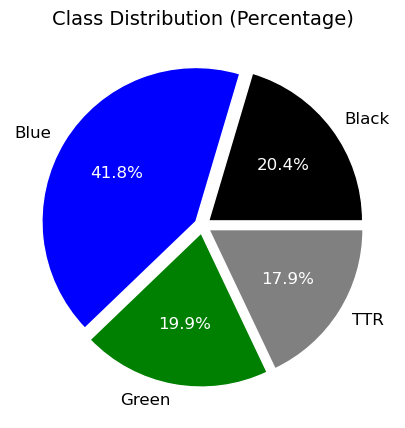

In [10]:
colors = ['black', 'blue', 'green', 'gray']
explode = [0.05] * len(CLASSES)  # Slightly pull slices out

plt.figure(figsize=(7, 5))
wedges, texts, autotexts = plt.pie(
    class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%',
    colors=colors, explode=explode, textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'white'}
)

# Improve visibility of percentage text
for autotext in autotexts:
    autotext.set_color('white')  # Change text color
    autotext.set_fontsize(12)  # Increase font size

plt.title("Class Distribution (Percentage)", fontsize=14)
plt.show()

#### Example Images from Each Class

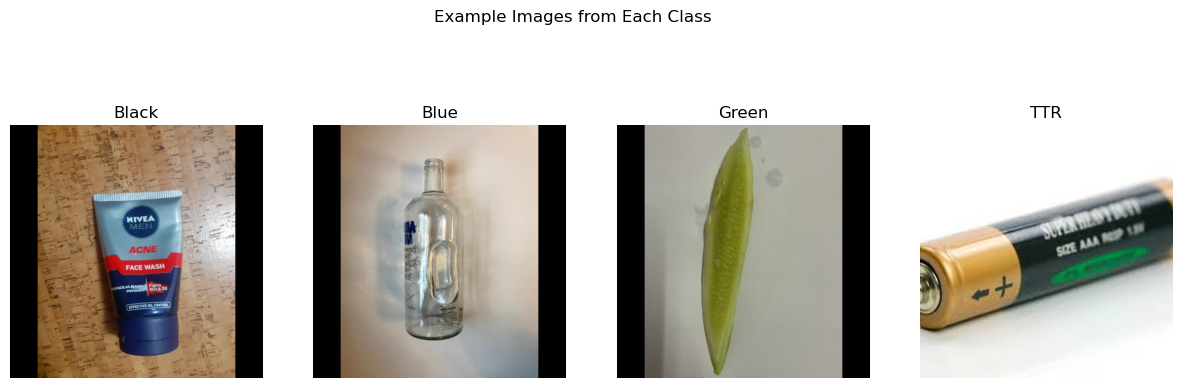

In [11]:
fig, axes = plt.subplots(1, len(CLASSES), figsize=(15, 5))
for i, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = os.listdir(class_path)
    if image_files:  # Ensure there are images
        image_path = os.path.join(class_path, image_files[0])
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")

plt.suptitle("Example Images from Each Class")
plt.show()

#### Image Size Distribution

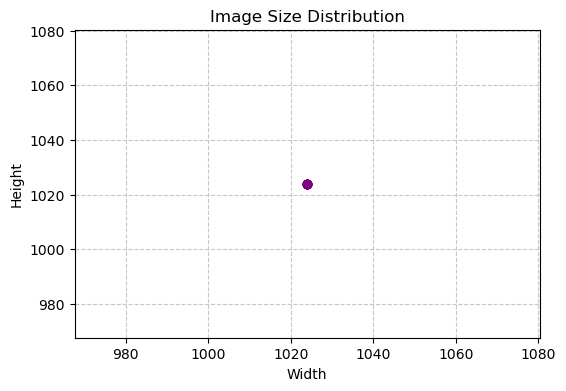

In [12]:
image_sizes = []
for class_name in CLASSES:
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = os.listdir(class_path)
    for image_file in image_files[:5]:  # Sample 5 images per class to get a quick size distribution
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            image_sizes.append(img.size)
            
# Convert sizes to separate width and height lists
widths, heights = zip(*image_sizes)

# Scatter plot of image sizes
plt.figure(figsize=(6, 4))
plt.scatter(widths, heights, alpha=0.6, color="purple")
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Size Distribution")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Aspect Ratio Distribution

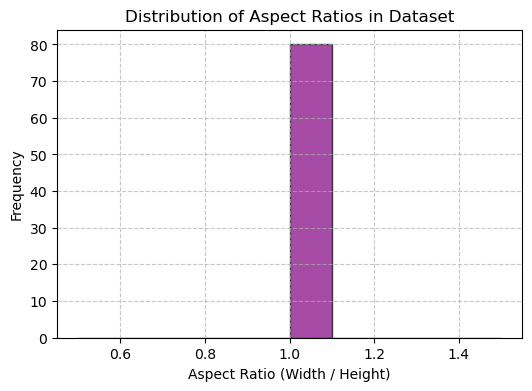

In [13]:
aspect_ratios = []

for class_name in CLASSES:
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = os.listdir(class_path)[:20]  # Sample 20 images per class
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            aspect_ratios.append(img.width / img.height)

plt.figure(figsize=(6, 4))
plt.hist(aspect_ratios, bins=10, color="purple", alpha=0.7, edgecolor="black")
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Distribution of Aspect Ratios in Dataset")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Image Brightness Distribution

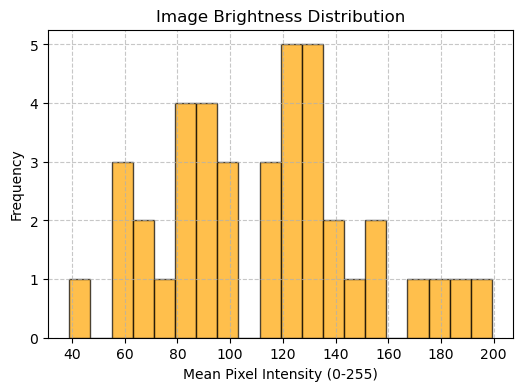

In [14]:
brightness_values = []

for class_name in CLASSES:
    class_path = os.path.join(DATA_DIR, class_name)
    image_files = os.listdir(class_path)[:10]  # Sample 10 images per class
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        with Image.open(image_path) as img:
            grayscale_img = img.convert("L")  # Convert to grayscale
            brightness_values.append(np.array(grayscale_img).mean())

plt.figure(figsize=(6, 4))
plt.hist(brightness_values, bins=20, color="orange", alpha=0.7, edgecolor="black")
plt.xlabel("Mean Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.title("Image Brightness Distribution")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [15]:
# Load text data from image filenames
texts, labels, image_paths = read_text_files_with_labels_and_image_paths(DATA_DIR)

# 1Word Cloud for Most Frequent Words in File Names
all_text = " ".join(texts)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

#### Wordcloud of Image Filenames

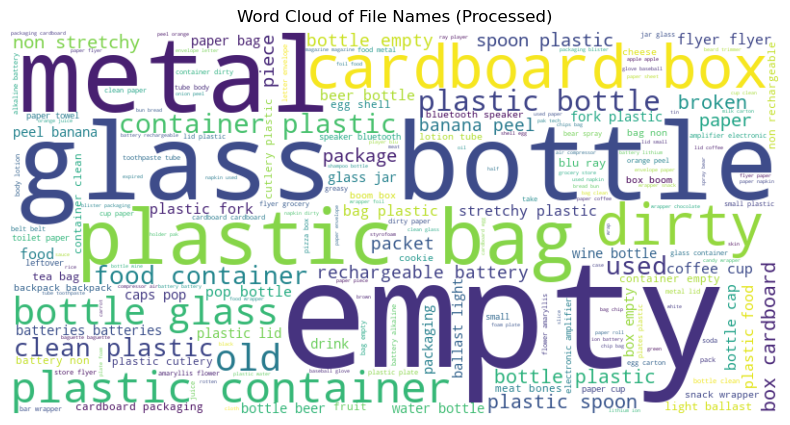

In [16]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of File Names (Processed)")
plt.show()

#### Distribution of File Name Lengths

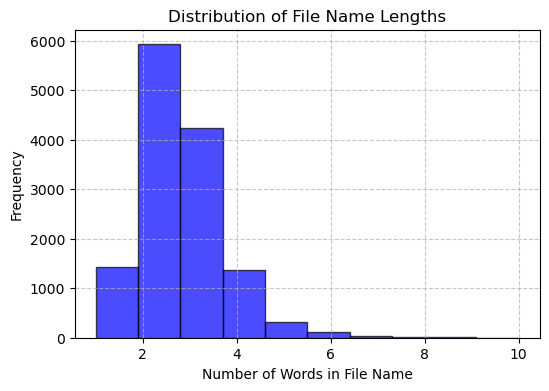

In [17]:
filename_lengths = [len(text.split()) for text in texts]

plt.figure(figsize=(6, 4))
plt.hist(filename_lengths, bins=10, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("Number of Words in File Name")
plt.ylabel("Frequency")
plt.title("Distribution of File Name Lengths")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


#### Most Common Words in File Names

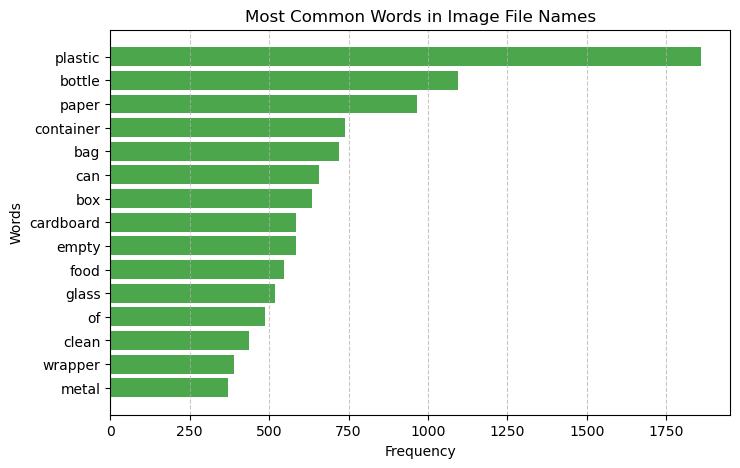

In [18]:
word_counts = Counter(all_text.split())
most_common_words = word_counts.most_common(15)  # Top 15 most common words

words, counts = zip(*most_common_words)
plt.figure(figsize=(8, 5))
plt.barh(words[::-1], counts[::-1], color="green", alpha=0.7)
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Most Common Words in Image File Names")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Analyze character lengths if image filenames

50th percentile (median): 15.0
75th percentile: 20.0
90th percentile: 25.0
95th percentile: 29.0
99th percentile: 37.0


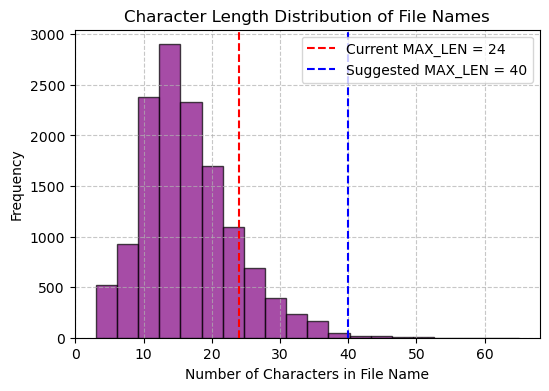

In [19]:
# Analyze character lengths
char_lengths = [len(text) for text in texts]

# Print percentiles
percentiles = np.percentile(char_lengths, [50, 75, 90, 95, 99])
print(f"50th percentile (median): {percentiles[0]}")
print(f"75th percentile: {percentiles[1]}")
print(f"90th percentile: {percentiles[2]}")
print(f"95th percentile: {percentiles[3]}")
print(f"99th percentile: {percentiles[4]}")

# Histogram of character lengths
plt.figure(figsize=(6, 4))
plt.hist(char_lengths, bins=20, color="purple", alpha=0.7, edgecolor="black")
plt.axvline(x=24, color="red", linestyle="--", label="Current MAX_LEN = 24")
plt.axvline(x=40, color="blue", linestyle="--", label="Suggested MAX_LEN = 40")
plt.xlabel("Number of Characters in File Name")
plt.ylabel("Frequency")
plt.title("Character Length Distribution of File Names")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Dataset Classes

In [20]:
class CustomTextDataset(Dataset):
    """Dataset class for text data."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
    
# Custom dataset class for images
class ImageDataset(Dataset):
    """Dataset class for image data."""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)



class MultimodalDataset(Dataset):
    """Dataset class for multimodal data (image + text)."""
    def __init__(self, image_dataset, text_dataset):
        self.image_dataset = image_dataset
        self.text_dataset = text_dataset

    def __len__(self):
        return min(len(self.image_dataset), len(self.text_dataset))

    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        text_data = self.text_dataset[idx]
        return {
            "image": image,
            "input_ids": text_data["input_ids"],
            "attention_mask": text_data["attention_mask"],
            "label": label
        }

## Main Experiment

### Model Definition

In [21]:
# ======================== Gated Fusion ========================
class GatedFusion(nn.Module):
    def __init__(self, feature_dim):
        super(GatedFusion, self).__init__()
        self.gate = nn.Linear(2 * feature_dim, feature_dim)  # Learnable gate
        self.sigmoid = nn.Sigmoid()  # Activation

    def forward(self, text_feat, image_feat):
        combined_feat = torch.cat((text_feat, image_feat), dim=1)
        gate_value = self.sigmoid(self.gate(combined_feat))  # Value between 0-1
        fused_feat = (gate_value * text_feat) + ((1 - gate_value) * image_feat)  # Weighted fusion
        return fused_feat

# ======================== Attention Fusion ========================
class AttentionFusion(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionFusion, self).__init__()
        self.Wq = nn.Linear(feature_dim, feature_dim)  # Query
        self.Wk = nn.Linear(feature_dim, feature_dim)  # Key
        self.Wv = nn.Linear(feature_dim, feature_dim)  # Value
        self.softmax = nn.Softmax(dim=1)

    def forward(self, fused_feat):
        q = self.Wq(fused_feat)
        k = self.Wk(fused_feat)
        v = self.Wv(fused_feat)
        
        attention_scores = self.softmax(torch.bmm(q.unsqueeze(1), k.unsqueeze(2)).squeeze(2))
        refined_feat = attention_scores * v  # Weighted fusion
        return refined_feat + fused_feat  # Residual connection

# ======================== Multimodal Classifier (Last Feature Extractor Layer Unfrozen) ========================
class MultimodalClassifier(nn.Module):
    """Multimodal model combining EfficientNetB0 and DistilBERT with partial fine-tuning."""
    def __init__(self, num_classes):
        super(MultimodalClassifier, self).__init__()

        # ----------- Image Feature Extractor (EfficientNetB0) -----------
        self.image_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        # Freeze all layers except the last one
        for param in self.image_model.features.parameters():
            param.requires_grad = False
        for param in self.image_model.features[-1:].parameters():  # Unfreeze last feature layer
            param.requires_grad = True

        num_ftrs = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()  # Remove classifier
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_IMAGE)
        )

        # ----------- Text Feature Extractor (DistilBERT) -----------
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze all layers except the last transformer layer
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.text_model.transformer.layer[-1:].parameters():  # Unfreeze last transformer layer
            param.requires_grad = True

        self.text_fc = nn.Sequential(
            nn.Linear(self.text_model.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_TEXT)
        )

        # ----------- Normalize Features -----------
        self.text_norm = nn.LayerNorm(256)
        self.image_norm = nn.LayerNorm(256)

        # ----------- Gated Fusion -----------
        self.gated_fusion = GatedFusion(feature_dim=256)

        # ----------- Attention Fusion -----------
        self.attention_fusion = AttentionFusion(feature_dim=256)

        # ----------- Fully Connected Fusion & Classification -----------
        self.fusion_fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(DROPOUT_FUSION)
        )

        self.dropout = nn.Dropout(DROPOUT_PREDICTION)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask, image_inputs):
        # Extract text features
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_output.last_hidden_state[:, 0, :])
        text_features = self.text_norm(text_features)

        # Extract image features
        image_features = self.image_fc(self.image_model(image_inputs))
        image_features = self.image_norm(image_features)

        # Apply Gated Fusion (balance text/image importance)
        gated_feat = self.gated_fusion(text_features, image_features)

        # Apply Attention Fusion (refine multimodal features)
        refined_feat = self.attention_fusion(gated_feat)

        # Final Fusion & Classification
        fused_features = self.fusion_fc(refined_feat)
        output = self.classifier(self.dropout(fused_features))
        return output


### Data setup

In [22]:
# Load dataset
texts, labels, image_paths = read_text_files_with_labels_and_image_paths(DATA_DIR)

# Log first and last 4 samples
logging.info("First 4 samples of dataset:\n")
logging.info(f"Texts: {texts[:4]}")
logging.info(f"Labels: {labels[:4]}")
logging.info(f"Image Paths: {image_paths[:4]}")

logging.info("\nLast 4 samples of dataset:\n")
logging.info(f"Texts: {texts[-4:]}")
logging.info(f"Labels: {labels[-4:]}")
logging.info(f"Image Paths: {image_paths[-4:]}")

2025-03-10 19:48:06,011 - INFO - First 4 samples of dataset:

2025-03-10 19:48:06,011 - INFO - Texts: ['Aero bar wrapper ' 'Broken Glass ' 'Broken rubber ' 'Butter Paper ']
2025-03-10 19:48:06,012 - INFO - Labels: [0 0 0 0]
2025-03-10 19:48:06,013 - INFO - Image Paths: ['C:\\NN Data\\garbage_data\\kfold_garbage_data\\Black\\Aero_bar_wrapper_1.png'
 'C:\\NN Data\\garbage_data\\kfold_garbage_data\\Black\\Broken_Glass_5291.png'
 'C:\\NN Data\\garbage_data\\kfold_garbage_data\\Black\\Broken_rubber_7263.png'
 'C:\\NN Data\\garbage_data\\kfold_garbage_data\\Black\\Butter_Paper_9976.png']
2025-03-10 19:48:06,013 - INFO - 
Last 4 samples of dataset:

2025-03-10 19:48:06,014 - INFO - Texts: ['wristwatch ' 'xbox controller ' 'xbox one controller '
 'zipper file bag ']
2025-03-10 19:48:06,014 - INFO - Labels: [3 3 3 3]
2025-03-10 19:48:06,015 - INFO - Image Paths: ['C:\\NN Data\\garbage_data\\kfold_garbage_data\\TTR\\wristwatch_3782.png'
 'C:\\NN Data\\garbage_data\\kfold_garbage_data\\TTR\\xbox_

### Split into test set and development set

In [23]:
# Split into a test set and development set
train_texts, test_texts, train_labels, test_labels, train_image_paths, test_image_paths = train_test_split(
    texts, labels, image_paths, test_size=TEST_SIZE, stratify=labels, random_state=42
)

# Log first 4 samples of test set
logging.info("First 4 samples of test set:\n")
logging.info(f"Texts: {test_texts[:4]}")
logging.info(f"Labels: {test_labels[:4]}")
logging.info(f"Image Paths: {test_image_paths[:4]}")

logging.info("\nLast 4 samples of test set:\n")
logging.info(f"Texts: {test_texts[-4:]}")
logging.info(f"Labels: {test_labels[-4:]}")
logging.info(f"Image Paths: {test_image_paths[-4:]}")

2025-03-10 19:48:06,470 - INFO - First 4 samples of test set:

2025-03-10 19:48:06,471 - INFO - Texts: ['ballast light ' 'Old Phones ' 'milk jug lid tab ' 'dirty dish sponge ']
2025-03-10 19:48:06,471 - INFO - Labels: [3 3 0 0]
2025-03-10 19:48:06,472 - INFO - Image Paths: ['C:\\NN Data\\garbage_data\\kfold_garbage_data\\TTR\\ballast_light_286.png'
 'C:\\NN Data\\garbage_data\\kfold_garbage_data\\TTR\\Old_Phones_7828.png'
 'C:\\NN Data\\garbage_data\\kfold_garbage_data\\Black\\milk_jug_lid_tab_1137.png'
 'C:\\NN Data\\garbage_data\\kfold_garbage_data\\Black\\dirty_dish_sponge_437.png']
2025-03-10 19:48:06,473 - INFO - 
Last 4 samples of test set:

2025-03-10 19:48:06,473 - INFO - Texts: ['empty glass jar ' 'non-stretchy plastic' 'backpack '
 'piece of broken glass ']
2025-03-10 19:48:06,474 - INFO - Labels: [1 0 3 0]
2025-03-10 19:48:06,474 - INFO - Image Paths: ['C:\\NN Data\\garbage_data\\kfold_garbage_data\\Blue\\empty_glass_jar_1609.png'
 'C:\\NN Data\\garbage_data\\kfold_garbage_d

### Define Transformations

In [24]:
# Define transformations
transform = {
    "train": transforms.Compose([
        transforms.Resize(IMAGE_SIZE), 
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Apply correct normalization
    ]),
    "val": transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Only resize + normalize
    ]),
    "test": transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)  # Only resize + normalize
    ])
}

# Tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def get_adaptive_train_transform(epoch, max_epoch=20):
    """Dynamically adjust augmentation intensity based on epoch number."""
    brightness_factor = 0.4 if epoch < max_epoch * 0.5 else 0.2
    rotation_angle = 30 if epoch < max_epoch * 0.3 else 15  # Reduce rotation intensity over time
    crop_scale = (0.6, 1.0) if epoch < max_epoch * 0.3 else (0.8, 1.0)  # More aggressive cropping early on

    return transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=brightness_factor, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomRotation(rotation_angle),
        transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),  # Higher variability in early training
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=crop_scale),
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZATION_STATS.mean, std=NORMALIZATION_STATS.std)
    ])

### DataLoader for test set

Create the dataloader for the test set and set aside for model evaluation.

In [25]:
# Create test dataset
test_image_dataset = ImageDataset(test_image_paths, test_labels, transform["test"])
test_text_dataset = CustomTextDataset(test_texts, test_labels, tokenizer, max_len=MAX_LEN)  # Ensure tokenizer is defined
test_multimodal_dataset = MultimodalDataset(test_image_dataset, test_text_dataset)

# DataLoader for test set
test_loader = DataLoader(test_multimodal_dataset, batch_size=BATCH_SIZE, shuffle=False)

Take a peek at a batch in the test set to verify that data has been correctly organized.

In [26]:
# Get one batch
for batch in test_loader:
    images = batch["image"]  # Image tensor
    input_ids = batch["input_ids"]  # Tokenized text tensor
    attention_mask = batch["attention_mask"]  # Attention mask
    labels = batch["label"]  # Labels tensor

    # Log shapes of tensors
    logging.info("[INFO] One Batch Sample Inspection:")
    logging.info(f"   Images Shape: {images.shape}")
    logging.info(f"   Input IDs Shape: {input_ids.shape}")
    logging.info(f"   Attention Mask Shape: {attention_mask.shape}")
    logging.info(f"   Labels Shape: {labels.shape}")

    # Log first sample details
    logging.info("\n[INFO] First Sample:")
    logging.info(f"   Image Tensor: {images[0]}")
    logging.info(f"   Input IDs: {input_ids[0]}")
    logging.info(f"   Attention Mask: {attention_mask[0]}")
    logging.info(f"   Label: {labels[0]}")

    break  # Stop after inspecting one batch


2025-03-10 19:48:13,614 - INFO - [INFO] One Batch Sample Inspection:
2025-03-10 19:48:13,615 - INFO -    Images Shape: torch.Size([64, 3, 224, 224])
2025-03-10 19:48:13,616 - INFO -    Input IDs Shape: torch.Size([64, 40])
2025-03-10 19:48:13,617 - INFO -    Attention Mask Shape: torch.Size([64, 40])
2025-03-10 19:48:13,617 - INFO -    Labels Shape: torch.Size([64])
2025-03-10 19:48:13,618 - INFO - 
[INFO] First Sample:
2025-03-10 19:48:13,622 - INFO -    Image Tensor: tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286,

### Apply Stratified K-Fold on the development set to split into train/val

In [27]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    logging.info(f"[INFO] Fold {fold + 1}/{K_FOLDS}")

    # Extract labels for current fold
    train_labels_fold = train_labels[train_idx]
    val_labels_fold = train_labels[val_idx]

    # Log class distributions
    logging.info("[INFO] Class Distributions:")
    logging.info(f"   Train Class Distribution: {Counter(train_labels_fold)}")
    logging.info(f"   Validation Class Distribution: {Counter(val_labels_fold)}")


2025-03-10 19:48:15,040 - INFO - [INFO] Fold 1/5
2025-03-10 19:48:15,042 - INFO - [INFO] Class Distributions:
2025-03-10 19:48:15,043 - INFO -    Train Class Distribution: Counter({np.int64(1): 3590, np.int64(0): 1754, np.int64(2): 1708, np.int64(3): 1542})
2025-03-10 19:48:15,043 - INFO -    Validation Class Distribution: Counter({np.int64(1): 898, np.int64(0): 438, np.int64(2): 427, np.int64(3): 386})
2025-03-10 19:48:15,045 - INFO - [INFO] Fold 2/5
2025-03-10 19:48:15,045 - INFO - [INFO] Class Distributions:
2025-03-10 19:48:15,046 - INFO -    Train Class Distribution: Counter({np.int64(1): 3591, np.int64(0): 1753, np.int64(2): 1708, np.int64(3): 1542})
2025-03-10 19:48:15,047 - INFO -    Validation Class Distribution: Counter({np.int64(1): 897, np.int64(0): 439, np.int64(2): 427, np.int64(3): 386})
2025-03-10 19:48:15,048 - INFO - [INFO] Fold 3/5
2025-03-10 19:48:15,048 - INFO - [INFO] Class Distributions:
2025-03-10 19:48:15,050 - INFO -    Train Class Distribution: Counter({np.in

### Verify k-fold was applied correctly

In [28]:
# Ensure no data leakage in folds
for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    train_set = set(train_idx)
    val_set = set(val_idx)

    # Check for intersection (should be empty)
    intersection = train_set.intersection(val_set)
    assert len(intersection) == 0, f"Data leakage detected in Fold {fold + 1}"

    logging.info(f"[INFO] No data leakage detected in Fold {fold + 1}")

2025-03-10 19:48:16,657 - INFO - [INFO] No data leakage detected in Fold 1
2025-03-10 19:48:16,659 - INFO - [INFO] No data leakage detected in Fold 2
2025-03-10 19:48:16,660 - INFO - [INFO] No data leakage detected in Fold 3
2025-03-10 19:48:16,661 - INFO - [INFO] No data leakage detected in Fold 4
2025-03-10 19:48:16,662 - INFO - [INFO] No data leakage detected in Fold 5


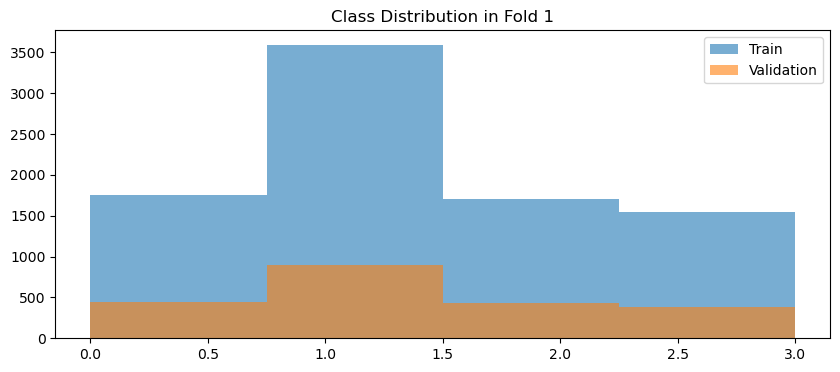

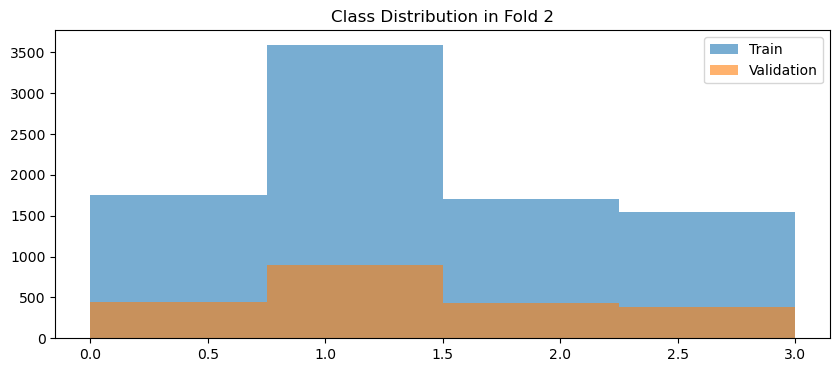

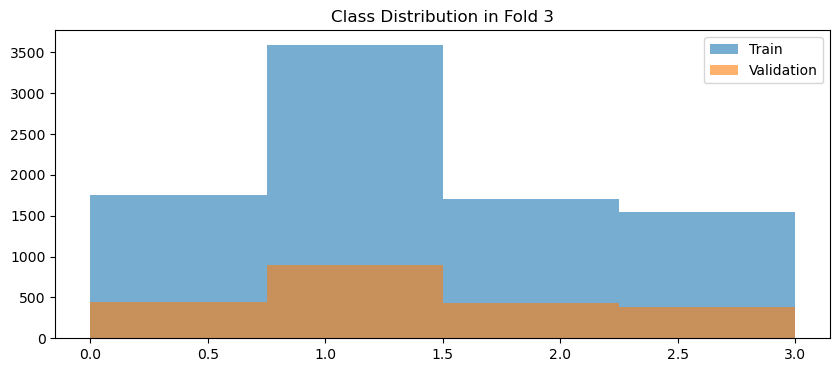

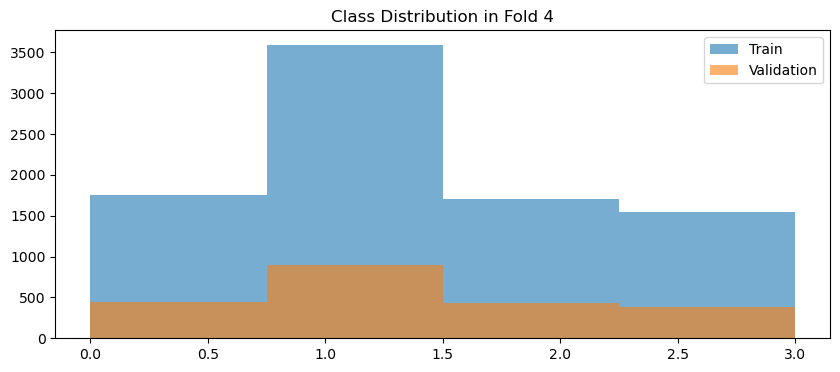

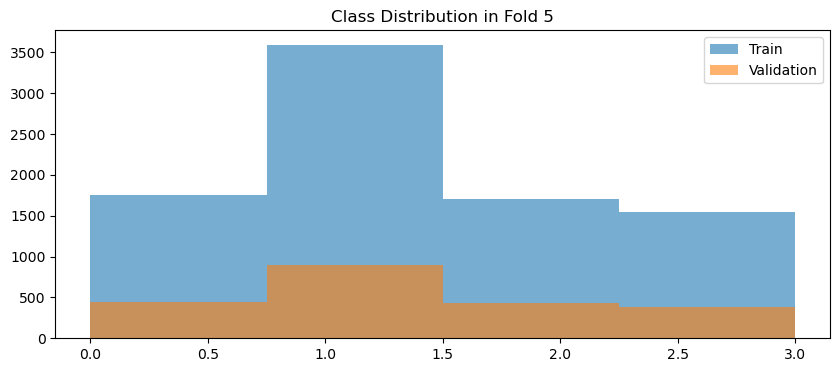

In [29]:
for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    train_labels_fold = train_labels[train_idx]
    val_labels_fold = train_labels[val_idx]

    plt.figure(figsize=(10, 4))
    plt.hist(train_labels_fold, bins=len(set(train_labels)), alpha=0.6, label="Train")
    plt.hist(val_labels_fold, bins=len(set(train_labels)), alpha=0.6, label="Validation")
    plt.title(f"Class Distribution in Fold {fold + 1}")
    plt.legend()
    plt.show()

## Train Model

### Evaluation Function

In [30]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct, total = 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in dataloader:
            # Move data to the appropriate device
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)  # Compute batch loss

            # Aggregate loss for averaging
            total_loss += loss.item() * labels.size(0)  # Multiply by batch size for proper averaging
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total  # Normalize loss over total samples
    accuracy = correct / total  # Compute accuracy

    return avg_loss, accuracy


## Adaptive Weight Decay

In [31]:
def adaptive_weight_decay(epoch, warmup_epochs=5, decay_factors=(0.1, 1.0)):
    """
    Returns a scaled weight decay based on epoch number.
    During warm-up, it applies a lower decay (decay_factors[0]).
    After warm-up, it applies full weight decay (decay_factors[1]).
    """
    if epoch < warmup_epochs:
        return decay_factors[0]  # Use lower decay during warm-up
    return decay_factors[1]  # Use normal decay afterward


### Train Loop

In [32]:
def train_model(model, dataloaders, criterion, optimizer, device, fold, use_mixup=True):
    initialize_wandb(fold)
    wandb.watch(model, log="all")

    best_val_loss = float("inf")  # Track best validation loss
    epochs_without_improvement = 0  # Track epochs without improvement until equals patience

    # ================ Multi-LR Warm-Up Scheduler ================
    def warmup_lambda_unfreeze_image(epoch):
        return min(1.0, (epoch + 1) / (WARMUP_EPOCHS * 0.8))  # Reaches full LR in 80% of warm-up epochs

    def warmup_lambda_unfreeze_text(epoch):
        return min(1.0, (epoch + 1) / (WARMUP_EPOCHS * 1.5))  # Slower for text, as transformers are sensitive

    def warmup_lambda_fusion(epoch):  
        return (epoch + 1) / (WARMUP_EPOCHS * 1.5) if epoch < WARMUP_EPOCHS else 1.0  

    def warmup_lambda_classifier(epoch):  
        return (epoch + 1) / (WARMUP_EPOCHS * 1.2) if epoch < WARMUP_EPOCHS else 1.0  

    def warmup_lambda_image(epoch):  
        return (epoch + 1) / WARMUP_EPOCHS if epoch < WARMUP_EPOCHS else 1.0  

    def warmup_lambda_text(epoch):  
        return (epoch + 1) / (WARMUP_EPOCHS * 2) if epoch < WARMUP_EPOCHS else 1.0  

    warmup_scheduler = LambdaLR(
        optimizer, 
        lr_lambda=[
            warmup_lambda_unfreeze_image,  # EfficientNet Unfrozen Layer
            warmup_lambda_unfreeze_text,  # DistilBERT Unfrozen Layer
            warmup_lambda_fusion,  # Fusion Layers
            warmup_lambda_classifier,  # Classifier Head
            warmup_lambda_image,  # General Image Feature Extractor
            warmup_lambda_text,  # General Text Feature Extractor
        ]
    )

    # ================ ReduceLROnPlateau Scheduler ================
    plateau_scheduler = ReduceLROnPlateau(
        optimizer, mode="min", factor=LR_SCHEDULING_FACTOR, patience=3, verbose=True
    )

    # AMP GradScaler
    scaler = GradScaler()

    epoch_start_time = time.time()  # Start total training timer
    logging.info("[TRAIN INFO] Starting Training...")
    # Training Loop
    for epoch in range(EPOCHS):
        logging.info(f"[TRAIN INFO] ============================== Epoch {epoch + 1}/{EPOCHS} ==============================")
        model.train()  # Set model to training mode
        total_train_loss = 0  # Track total training loss for the epoch
        batch_train_loss = 0  # Track batch loss for gradient accumulation
        step = 0  # Track the number of batches processed

        # ================ Apply Adaptive Weight Decay at Start of Epoch ================
        for param_group in optimizer.param_groups:
            if "image_model" in param_group["params"][0].__str__():  
                param_group["weight_decay"] = WEIGHT_DECAY_UNFREEZE_IMAGE * adaptive_weight_decay(epoch, 5, 0.1)
            elif "text_model" in param_group["params"][0].__str__():  
                param_group["weight_decay"] = WEIGHT_DECAY_UNFREEZE_TEXT * adaptive_weight_decay(epoch, 5, 0.1)
            elif "fusion_fc" in param_group["params"][0].__str__():  
                param_group["weight_decay"] = WEIGHT_DECAY_FUSION * adaptive_weight_decay(epoch, 5, 0.1)
            elif "classifier" in param_group["params"][0].__str__():  
                param_group["weight_decay"] = WEIGHT_DECAY_PREDICTION * adaptive_weight_decay(epoch, 5, 0.1)


        logging.info(f"[TRAIN INFO] Updated Weight Decays - EfficientNet: {optimizer.param_groups[0]['weight_decay']:.6f}, "
                     f"DistilBERT: {optimizer.param_groups[1]['weight_decay']:.6f}, Fusion: {optimizer.param_groups[2]['weight_decay']:.6f}, "
                     f"Classifier: {optimizer.param_groups[3]['weight_decay']:.6f}")

        # Warm-Up Step
        if epoch < WARMUP_EPOCHS:
            warmup_scheduler.step()
            logging.info(f"[TRAIN INFO] Warm-Up Phase: LR Adjusted - Image: {optimizer.param_groups[0]['lr']:.6f}, Text: {optimizer.param_groups[1]['lr']:.6f}, Fusion: {optimizer.param_groups[2]['lr']:.6f}, Classifier: {optimizer.param_groups[3]['lr']:.6f}")

        train_transforms = get_adaptive_train_transform(epoch)
        dataloaders["train_loader"].dataset.transform = train_transforms  

        # Training phase
        for batch in dataloaders["train_loader"]:
            # Move data to device
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # # Forward pass
            # # Log GPU memory usage before forward pass
            # mem_allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)  # Convert to MB
            # mem_reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)  # Convert to MB
            # logging.info(f"[GPU INFO] Before Forward Pass - Memory Allocated: {mem_allocated:.2f}MB, Reserved: {mem_reserved:.2f}MB")

            with autocast():
                outputs = model(input_ids, attention_mask, images)  # Send inputs to network and receive outputs
                loss = criterion(outputs, labels) / GRAD_ACCUM_STEPS  # Normalize loss for gradient accumulation

            # # Log GPU memory usage after forward pass
            # mem_allocated_after = torch.cuda.memory_allocated(device) / (1024 ** 2)
            # mem_reserved_after = torch.cuda.memory_reserved(device) / (1024 ** 2)
            # logging.info(f"[GPU INFO] After Forward Pass - Memory Allocated: {mem_allocated_after:.2f}MB, Reserved: {mem_reserved_after:.2f}MB")

            loss.backward()  # Backpropagate to compute gradients
            
            # Accumulate batch loss
            batch_train_loss += loss.item()
            total_train_loss += loss.item() * GRAD_ACCUM_STEPS  # Undo normalization for total loss

            step += 1

            # Perform optimizer step before learning rate scheduler step
            if step % GRAD_ACCUM_STEPS == 0 or step == len(dataloaders["train_loader"]):
                optimizer.step()
                optimizer.zero_grad()

                # Log batch loss
                logging.info(f"[TRAIN INFO] Batch {step}/{len(dataloaders['train_loader'])}, Accumulated loss over {GRAD_ACCUM_STEPS} batches: {batch_train_loss:.4f}")
                batch_train_loss = 0  # Reset batch loss for the next accumulation

        # Validation step to see how well model performs this epoch
        logging.info(f"[TRAIN INFO] Evaluating model...")
        val_loss, val_acc = evaluate_model(model, dataloaders["val_loader"], device)
        avg_train_loss = total_train_loss / len(dataloaders["train_loader"])

        # **Learning Rate Scheduler Handling**
        if epoch < WARMUP_EPOCHS:
            warmup_scheduler.step()  # Only apply warmup during the first few epochs
        else:
            plateau_scheduler.step(val_loss)  # Start ReduceLROnPlateau **AFTER** warm-up

        # Log weight decay and learning rate updates
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "train_val_loss_diff": avg_train_loss - val_loss,  # Track overfitting tendency
            "learning_rate_image": optimizer.param_groups[0]["lr"],
            "learning_rate_text": optimizer.param_groups[1]["lr"],
            "learning_rate_fusion": optimizer.param_groups[2]["lr"],
            "learning_rate_classifier": optimizer.param_groups[3]["lr"],
            "weight_decay_image": optimizer.param_groups[0]["weight_decay"],
            "weight_decay_text": optimizer.param_groups[1]["weight_decay"],
            "weight_decay_fusion": optimizer.param_groups[2]["weight_decay"],
            "weight_decay_classifier": optimizer.param_groups[3]["weight_decay"],
            "grad_accum_steps": GRAD_ACCUM_STEPS,  # Track gradient accumulation settings
            "early_stopping_epochs": epochs_without_improvement  # Track early stopping
        })

        logging.info(f"[TRAIN INFO] Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check for improvement in validation loss
        if val_loss < best_val_loss - CONVERGENCE_THRESHOLD:  # If loss improves, save the model
            best_val_loss = val_loss
            epochs_without_improvement = 0  # Reset epochs without improvement counter for patience
            torch.save(model.state_dict(), f"best_model_fold_{fold + 1}.pth")
            logging.info(f"[TRAIN INFO] Best Model Saved for Fold {fold + 1}")
        else:
            epochs_without_improvement += 1  # Increment until patience reached

        # Early stopping if no improvement for epochs
        if epochs_without_improvement >= PATIENCE:
            total_training_time = time.time() - epoch_start_time
            logging.info(f"[TRAIN INFO] Early stopping at epoch {epoch + 1} as validation loss did not improve for {PATIENCE} epochs.")
            logging.info(f"[TRAIN INFO] Total Time: {total_training_time:.2f}s")
            wandb.finish()
            break

    total_training_time = time.time() - epoch_start_time
    logging.info(f"[TRAIN INFO] Fold {fold + 1} Training Complete at epoch {epoch + 1}. Total Time: {total_training_time:.2f}s")
    wandb.finish()

In [33]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

logging.info("[K-FOLD INFO] Starting Stratified K-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(skf.split(train_texts, train_labels)):
    fold_start_time = time.time()  # Start timing for this fold
    logging.info(f"[K-FOLD INFO] ============================== Fold {fold+1}/{K_FOLDS} ==============================")

    # Get train and validation subsets
    train_texts_fold = train_texts[train_idx]
    val_texts_fold = train_texts[val_idx]
    train_labels_fold = train_labels[train_idx]
    val_labels_fold = train_labels[val_idx]
    train_image_paths_fold = train_image_paths[train_idx]
    val_image_paths_fold = train_image_paths[val_idx]

    logging.info(f"[K-FOLD INFO] Fold {fold+1}:")
    logging.info(f"   Train Samples: {len(train_texts_fold)}")
    logging.info(f"   Validation Samples: {len(val_texts_fold)}")

    # Create dataset objects
    train_image_dataset = ImageDataset(train_image_paths_fold, train_labels_fold, transform["train"])
    val_image_dataset = ImageDataset(val_image_paths_fold, val_labels_fold, transform["val"])
    
    train_text_dataset = CustomTextDataset(train_texts_fold, train_labels_fold, tokenizer, max_len=MAX_LEN)
    val_text_dataset = CustomTextDataset(val_texts_fold, val_labels_fold, tokenizer, max_len=MAX_LEN)

    # Create multimodal datasets
    train_multimodal_dataset = MultimodalDataset(train_image_dataset, train_text_dataset)
    val_multimodal_dataset = MultimodalDataset(val_image_dataset, val_text_dataset)

    logging.info(f"[K-FOLD INFO] Created multimodal datasets for Fold {fold+1}")

    # Create DataLoaders
    dataloaders = {
        "train_loader": DataLoader(train_multimodal_dataset, batch_size=BATCH_SIZE, shuffle=True),
        "val_loader": DataLoader(val_multimodal_dataset, batch_size=BATCH_SIZE, shuffle=False)
    }

    logging.info(f"[K-FOLD INFO] DataLoaders initialized for Fold {fold+1}:")
    logging.info(f"   Train batches: {len(dataloaders['train_loader'])}, Validation batches: {len(dataloaders['val_loader'])}")

    # Initialize model, optimizer, and criterion
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultimodalClassifier(num_classes=NUM_CLASSES).to(device)

    logging.info(f"[K-FOLD INFO] Model initialized on {device} for Fold {fold+1}")

    # Define Optimizer using AdamW
    optimizer = optim.AdamW([
        {"params": model.image_model.features[-1:].parameters(), "lr": LEARNING_RATE_UNFREEZE_IMAGE, "weight_decay": WEIGHT_DECAY_UNFREEZE_IMAGE},  # Unfrozen EfficientNet layer
        {"params": model.text_model.transformer.layer[-1:].parameters(), "lr": LEARNING_RATE_UNFREEZE_TEXT, "weight_decay": WEIGHT_DECAY_UNFREEZE_TEXT},  # Unfrozen DistilBERT layer
        {"params": model.image_fc.parameters(), "lr": LEARNING_RATE_IMAGE, "weight_decay": 0}, 
        {"params": model.text_fc.parameters(), "lr": LEARNING_RATE_TEXT, "weight_decay": 0},
        {"params": model.fusion_fc.parameters(), "lr": LEARNING_RATE_FUSION, "weight_decay": WEIGHT_DECAY_FUSION},  
        {"params": model.classifier.parameters(), "lr": LEARNING_RATE_CLASSIFIER, "weight_decay": WEIGHT_DECAY_PREDICTION}  
    ], betas=(0.9, 0.999), eps=1e-8)  # Default AdamW betas and eps


    logging.info(f"[K-FOLD INFO] Optimizer initialized for Fold {fold+1}:")
    # Define Loss Function
    criterion = torch.nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING_PREDICTION) 

    logging.info(f"[K-FOLD INFO] Loss function initialized for Fold {fold+1}")

    # Train model for this fold
    train_model(model, dataloaders, criterion, optimizer, device, fold, use_mixup=True)

    # Measure Fold Time
    fold_time = time.time() - fold_start_time
    logging.info(f"[K-FOLD INFO] Fold {fold+1} completed in {fold_time:.2f} seconds")


2025-03-10 19:48:43,921 - INFO - [K-FOLD INFO] Starting Stratified K-Fold Cross-Validation...
2025-03-10 19:48:43,924 - INFO - [K-FOLD INFO] ============================== Fold 1/5 ==============================
2025-03-10 19:48:43,926 - INFO - [K-FOLD INFO] Fold 1:
2025-03-10 19:48:43,927 - INFO -    Train Samples: 8594
2025-03-10 19:48:43,927 - INFO -    Validation Samples: 2149
2025-03-10 19:48:43,928 - INFO - [K-FOLD INFO] Created multimodal datasets for Fold 1
2025-03-10 19:48:43,928 - INFO - [K-FOLD INFO] DataLoaders initialized for Fold 1:
2025-03-10 19:48:43,929 - INFO -    Train batches: 135, Validation batches: 34
2025-03-10 19:48:44,668 - INFO - [K-FOLD INFO] Model initialized on cuda for Fold 1
2025-03-10 19:48:44,669 - INFO - [K-FOLD INFO] Optimizer initialized for Fold 1:
2025-03-10 19:48:44,670 - INFO - [K-FOLD INFO] Loss function initialized for Fold 1


wandb: Currently logged in as: shcau (shcau-university-of-calgary-in-alberta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


c:\Users\arkzs\miniforge3\envs\enel645_torch_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\arkzs\AppData\Local\Temp\ipykernel_35900\3736874880.py:45: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


2025-03-10 19:48:46,934 - INFO - [TRAIN INFO] Starting Training...
2025-03-10 19:48:46,934 - INFO - [TRAIN INFO] ============================== Epoch 1/50 ==============================
2025-03-10 19:48:47,148 - INFO - [TRAIN INFO] Updated Weight Decays - EfficientNet: 0.000100, DistilBERT: 0.000020, Fusion: 0.000000, Classifier: 0.000000


c:\Users\arkzs\miniforge3\envs\enel645_torch_env\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


2025-03-10 19:48:47,149 - INFO - [TRAIN INFO] Warm-Up Phase: LR Adjusted - Image: 0.000500, Text: 0.000013, Fusion: 0.000267, Classifier: 0.000007


C:\Users\arkzs\AppData\Local\Temp\ipykernel_35900\3736874880.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


2025-03-10 19:48:55,842 - INFO - [TRAIN INFO] Batch 4/135, Accumulated loss over 4 batches: 1.4504
2025-03-10 19:49:04,065 - INFO - [TRAIN INFO] Batch 8/135, Accumulated loss over 4 batches: 1.3439
2025-03-10 19:49:12,065 - INFO - [TRAIN INFO] Batch 12/135, Accumulated loss over 4 batches: 1.3246
2025-03-10 19:49:20,264 - INFO - [TRAIN INFO] Batch 16/135, Accumulated loss over 4 batches: 1.2635
2025-03-10 19:49:28,063 - INFO - [TRAIN INFO] Batch 20/135, Accumulated loss over 4 batches: 1.2600
2025-03-10 19:49:36,253 - INFO - [TRAIN INFO] Batch 24/135, Accumulated loss over 4 batches: 1.2445
2025-03-10 19:49:44,391 - INFO - [TRAIN INFO] Batch 28/135, Accumulated loss over 4 batches: 1.2359
2025-03-10 19:49:52,436 - INFO - [TRAIN INFO] Batch 32/135, Accumulated loss over 4 batches: 1.2049
2025-03-10 19:50:00,704 - INFO - [TRAIN INFO] Batch 36/135, Accumulated loss over 4 batches: 1.1404
2025-03-10 19:50:08,849 - INFO - [TRAIN INFO] Batch 40/135, Accumulated loss over 4 batches: 1.1314
20

early_stopping_epochs,▁▁▁▁▂▁▁▁▂▃▃▄▅▆▆▇█
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
grad_accum_steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate_classifier,▄▇████████▃▃▃▃▁▁▁
learning_rate_fusion,▃▅████████▃▃▃▃▁▁▁
learning_rate_image,▆█████████▃▃▃▃▁▁▁
learning_rate_text,▃▅▇███████▃▃▃▃▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_val_loss_diff,█▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▆▇▇█▇▇████████
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁


2025-03-10 21:25:37,548 - INFO - [TRAIN INFO] Fold 1 Training Complete at epoch 17. Total Time: 5810.61s
2025-03-10 21:25:37,556 - INFO - [K-FOLD INFO] Fold 1 completed in 5813.63 seconds
2025-03-10 21:25:37,558 - INFO - [K-FOLD INFO] ============================== Fold 2/5 ==============================
2025-03-10 21:25:37,565 - INFO - [K-FOLD INFO] Fold 2:
2025-03-10 21:25:37,565 - INFO -    Train Samples: 8594
2025-03-10 21:25:37,566 - INFO -    Validation Samples: 2149
2025-03-10 21:25:37,567 - INFO - [K-FOLD INFO] Created multimodal datasets for Fold 2
2025-03-10 21:25:37,568 - INFO - [K-FOLD INFO] DataLoaders initialized for Fold 2:
2025-03-10 21:25:37,569 - INFO -    Train batches: 135, Validation batches: 34
2025-03-10 21:25:38,392 - INFO - [K-FOLD INFO] Model initialized on cuda for Fold 2
2025-03-10 21:25:38,393 - INFO - [K-FOLD INFO] Optimizer initialized for Fold 2:
2025-03-10 21:25:38,393 - INFO - [K-FOLD INFO] Loss function initialized for Fold 2


2025-03-10 21:25:39,211 - INFO - [TRAIN INFO] Starting Training...
2025-03-10 21:25:39,212 - INFO - [TRAIN INFO] ============================== Epoch 1/50 ==============================
2025-03-10 21:25:39,346 - INFO - [TRAIN INFO] Updated Weight Decays - EfficientNet: 0.000100, DistilBERT: 0.000020, Fusion: 0.000000, Classifier: 0.000000
2025-03-10 21:25:39,347 - INFO - [TRAIN INFO] Warm-Up Phase: LR Adjusted - Image: 0.000500, Text: 0.000013, Fusion: 0.000267, Classifier: 0.000007
2025-03-10 21:25:47,891 - INFO - [TRAIN INFO] Batch 4/135, Accumulated loss over 4 batches: 1.3780
2025-03-10 21:25:55,826 - INFO - [TRAIN INFO] Batch 8/135, Accumulated loss over 4 batches: 1.3058
2025-03-10 21:26:03,802 - INFO - [TRAIN INFO] Batch 12/135, Accumulated loss over 4 batches: 1.3207
2025-03-10 21:26:11,844 - INFO - [TRAIN INFO] Batch 16/135, Accumulated loss over 4 batches: 1.3270
2025-03-10 21:26:19,989 - INFO - [TRAIN INFO] Batch 20/135, Accumulated loss over 4 batches: 1.2793
2025-03-10 21:

early_stopping_epochs,▁▁▁▁▁▁▂▃▁▂▃▃▄▅▆▆▇█
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
grad_accum_steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate_classifier,▄▇█████████▃▃▃▃▁▁▁
learning_rate_fusion,▃▅█████████▃▃▃▃▁▁▁
learning_rate_image,▆██████████▃▃▃▃▁▁▁
learning_rate_text,▃▅▇████████▃▃▃▃▁▁▁
train_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train_val_loss_diff,█▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▇█▇█████████
val_loss,█▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁


2025-03-10 23:06:45,479 - INFO - [TRAIN INFO] Fold 2 Training Complete at epoch 18. Total Time: 6066.27s
2025-03-10 23:06:45,489 - INFO - [K-FOLD INFO] Fold 2 completed in 6067.93 seconds
2025-03-10 23:06:45,489 - INFO - [K-FOLD INFO] ============================== Fold 3/5 ==============================
2025-03-10 23:06:45,493 - INFO - [K-FOLD INFO] Fold 3:
2025-03-10 23:06:45,494 - INFO -    Train Samples: 8594
2025-03-10 23:06:45,494 - INFO -    Validation Samples: 2149
2025-03-10 23:06:45,495 - INFO - [K-FOLD INFO] Created multimodal datasets for Fold 3
2025-03-10 23:06:45,496 - INFO - [K-FOLD INFO] DataLoaders initialized for Fold 3:
2025-03-10 23:06:45,497 - INFO -    Train batches: 135, Validation batches: 34
2025-03-10 23:06:46,265 - INFO - [K-FOLD INFO] Model initialized on cuda for Fold 3
2025-03-10 23:06:46,267 - INFO - [K-FOLD INFO] Optimizer initialized for Fold 3:
2025-03-10 23:06:46,268 - INFO - [K-FOLD INFO] Loss function initialized for Fold 3


2025-03-10 23:06:47,152 - INFO - [TRAIN INFO] Starting Training...
2025-03-10 23:06:47,153 - INFO - [TRAIN INFO] ============================== Epoch 1/50 ==============================
2025-03-10 23:06:47,271 - INFO - [TRAIN INFO] Updated Weight Decays - EfficientNet: 0.000100, DistilBERT: 0.000020, Fusion: 0.000000, Classifier: 0.000000
2025-03-10 23:06:47,272 - INFO - [TRAIN INFO] Warm-Up Phase: LR Adjusted - Image: 0.000500, Text: 0.000013, Fusion: 0.000267, Classifier: 0.000007
2025-03-10 23:06:56,567 - INFO - [TRAIN INFO] Batch 4/135, Accumulated loss over 4 batches: 1.4388
2025-03-10 23:07:05,797 - INFO - [TRAIN INFO] Batch 8/135, Accumulated loss over 4 batches: 1.3056
2025-03-10 23:07:14,962 - INFO - [TRAIN INFO] Batch 12/135, Accumulated loss over 4 batches: 1.3233
2025-03-10 23:07:24,170 - INFO - [TRAIN INFO] Batch 16/135, Accumulated loss over 4 batches: 1.2286
2025-03-10 23:07:33,260 - INFO - [TRAIN INFO] Batch 20/135, Accumulated loss over 4 batches: 1.2872
2025-03-10 23:

early_stopping_epochs,▁▁▁▁▁▁▁▁▁▂▁▂▃▃▄▅▆▆▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
grad_accum_steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate_classifier,▄▇███████████▃▃▃▃▁▁▁
learning_rate_fusion,▃▅███████████▃▃▃▃▁▁▁
learning_rate_image,▆████████████▃▃▃▃▁▁▁
learning_rate_text,▃▅▇██████████▃▃▃▃▁▁▁
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_val_loss_diff,█▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▆▇▇▇█▇▇████████
val_loss,█▄▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁


2025-03-11 01:01:09,659 - INFO - [TRAIN INFO] Fold 3 Training Complete at epoch 20. Total Time: 6862.51s
2025-03-11 01:01:09,667 - INFO - [K-FOLD INFO] Fold 3 completed in 6864.18 seconds
2025-03-11 01:01:09,668 - INFO - [K-FOLD INFO] ============================== Fold 4/5 ==============================
2025-03-11 01:01:09,670 - INFO - [K-FOLD INFO] Fold 4:
2025-03-11 01:01:09,670 - INFO -    Train Samples: 8595
2025-03-11 01:01:09,672 - INFO -    Validation Samples: 2148
2025-03-11 01:01:09,673 - INFO - [K-FOLD INFO] Created multimodal datasets for Fold 4
2025-03-11 01:01:09,674 - INFO - [K-FOLD INFO] DataLoaders initialized for Fold 4:
2025-03-11 01:01:09,675 - INFO -    Train batches: 135, Validation batches: 34
2025-03-11 01:01:10,987 - INFO - [K-FOLD INFO] Model initialized on cuda for Fold 4
2025-03-11 01:01:10,988 - INFO - [K-FOLD INFO] Optimizer initialized for Fold 4:
2025-03-11 01:01:10,989 - INFO - [K-FOLD INFO] Loss function initialized for Fold 4


2025-03-11 01:01:13,247 - INFO - [TRAIN INFO] Starting Training...
2025-03-11 01:01:13,248 - INFO - [TRAIN INFO] ============================== Epoch 1/50 ==============================
2025-03-11 01:01:13,360 - INFO - [TRAIN INFO] Updated Weight Decays - EfficientNet: 0.000100, DistilBERT: 0.000020, Fusion: 0.000000, Classifier: 0.000000
2025-03-11 01:01:13,361 - INFO - [TRAIN INFO] Warm-Up Phase: LR Adjusted - Image: 0.000500, Text: 0.000013, Fusion: 0.000267, Classifier: 0.000007
2025-03-11 01:01:21,970 - INFO - [TRAIN INFO] Batch 4/135, Accumulated loss over 4 batches: 1.4885
2025-03-11 01:01:30,767 - INFO - [TRAIN INFO] Batch 8/135, Accumulated loss over 4 batches: 1.3421
2025-03-11 01:01:39,497 - INFO - [TRAIN INFO] Batch 12/135, Accumulated loss over 4 batches: 1.3607
2025-03-11 01:01:48,160 - INFO - [TRAIN INFO] Batch 16/135, Accumulated loss over 4 batches: 1.2704
2025-03-11 01:01:56,974 - INFO - [TRAIN INFO] Batch 20/135, Accumulated loss over 4 batches: 1.3327
2025-03-11 01:

early_stopping_epochs,▁▁▁▁▁▁▁▁▂▃▁▂▃▃▄▅▆▆▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
grad_accum_steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate_classifier,▄▇█████████████▃▃▃▃▁
learning_rate_fusion,▃▅█████████████▃▃▃▃▁
learning_rate_image,▆██████████████▃▃▃▃▁
learning_rate_text,▃▅▇████████████▃▃▃▃▁
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_val_loss_diff,█▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇▇▇██████▇████
val_loss,█▄▂▂▂▁▁▂▁▁▁▁▂▁▁▂▂▂▁▂


2025-03-11 02:56:46,278 - INFO - [TRAIN INFO] Fold 4 Training Complete at epoch 20. Total Time: 6933.03s
2025-03-11 02:56:46,279 - INFO - [K-FOLD INFO] Fold 4 completed in 6936.61 seconds
2025-03-11 02:56:46,280 - INFO - [K-FOLD INFO] ============================== Fold 5/5 ==============================
2025-03-11 02:56:46,282 - INFO - [K-FOLD INFO] Fold 5:
2025-03-11 02:56:46,283 - INFO -    Train Samples: 8595
2025-03-11 02:56:46,283 - INFO -    Validation Samples: 2148
2025-03-11 02:56:46,284 - INFO - [K-FOLD INFO] Created multimodal datasets for Fold 5
2025-03-11 02:56:46,285 - INFO - [K-FOLD INFO] DataLoaders initialized for Fold 5:
2025-03-11 02:56:46,286 - INFO -    Train batches: 135, Validation batches: 34
2025-03-11 02:56:46,885 - INFO - [K-FOLD INFO] Model initialized on cuda for Fold 5
2025-03-11 02:56:46,886 - INFO - [K-FOLD INFO] Optimizer initialized for Fold 5:
2025-03-11 02:56:46,887 - INFO - [K-FOLD INFO] Loss function initialized for Fold 5


2025-03-11 02:56:49,230 - INFO - [TRAIN INFO] Starting Training...
2025-03-11 02:56:49,231 - INFO - [TRAIN INFO] ============================== Epoch 1/50 ==============================
2025-03-11 02:56:49,347 - INFO - [TRAIN INFO] Updated Weight Decays - EfficientNet: 0.000100, DistilBERT: 0.000020, Fusion: 0.000000, Classifier: 0.000000
2025-03-11 02:56:49,347 - INFO - [TRAIN INFO] Warm-Up Phase: LR Adjusted - Image: 0.000500, Text: 0.000013, Fusion: 0.000267, Classifier: 0.000007
2025-03-11 02:56:57,616 - INFO - [TRAIN INFO] Batch 4/135, Accumulated loss over 4 batches: 1.3938
2025-03-11 02:57:06,177 - INFO - [TRAIN INFO] Batch 8/135, Accumulated loss over 4 batches: 1.3242
2025-03-11 02:57:14,394 - INFO - [TRAIN INFO] Batch 12/135, Accumulated loss over 4 batches: 1.2571
2025-03-11 02:57:22,794 - INFO - [TRAIN INFO] Batch 16/135, Accumulated loss over 4 batches: 1.3231
2025-03-11 02:57:31,216 - INFO - [TRAIN INFO] Batch 20/135, Accumulated loss over 4 batches: 1.2523
2025-03-11 02:

early_stopping_epochs,▁▁▁▁▁▁▂▁▂▁▂▁▂▃▃▄▅▆▆▇█
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
grad_accum_steps,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate_classifier,▄▇████████████▃▃▃▃▁▁▁
learning_rate_fusion,▃▅████████████▃▃▃▃▁▁▁
learning_rate_image,▆█████████████▃▃▃▃▁▁▁
learning_rate_text,▃▅▇███████████▃▃▃▃▁▁▁
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_val_loss_diff,█▆▅▄▄▃▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇█▇██▇████████
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁


2025-03-11 04:57:19,036 - INFO - [TRAIN INFO] Fold 5 Training Complete at epoch 21. Total Time: 7229.81s
2025-03-11 04:57:19,044 - INFO - [K-FOLD INFO] Fold 5 completed in 7232.76 seconds


In [ ]:
for fold in range(K_FOLDS):
    logging.info(f"\n[TEST INFO] Evaluating Fold {fold + 1} on Test Set...")

    # Load best model for the fold
    model = MultimodalClassifier(num_classes=NUM_CLASSES).to(device)
    model_path = f"best_model_fold_{fold + 1}.pth"
    
    try:
        model.load_state_dict(torch.load(model_path))
        logging.info(f"[TEST INFO] Loaded best model for Fold {fold + 1} from {model_path}")
    except FileNotFoundError:
        logging.error(f"[ERROR] Model file {model_path} not found! Skipping Fold {fold + 1} evaluation.")
        continue  # Skip to the next fold if model file is missing

    model.eval()  # Set to evaluation mode

    # Evaluate model on test data
    test_loss, test_acc = evaluate_model(model, test_loader, device)

    # Log test set performance for the fold
    logging.info(f"[TEST INFO] Fold {fold + 1} Test Performance:")
    logging.info(f"   Test Loss: {test_loss:.4f}")
    logging.info(f"   Test Accuracy: {test_acc:.2f}%")